# 타이타닉 생존자 예측

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 데이터 전처리

- Feature selection

In [12]:
df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked','deck']]
print(df.shape)
df.head(15)

(891, 9)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.000000,1,0,7.2500,S,NaN
1,1,1,female,38.000000,1,0,71.2833,C,C
2,1,3,female,26.000000,0,0,7.9250,S,NaN
3,1,1,female,35.000000,1,0,53.1000,S,C
4,0,3,male,35.000000,0,0,8.0500,S,NaN
5,0,3,male,29.699118,0,0,8.4583,Q,NaN
6,0,1,male,54.000000,0,0,51.8625,S,E
7,0,3,male,2.000000,3,1,21.0750,S,NaN
8,1,3,female,27.000000,0,2,11.1333,S,NaN
9,1,2,female,14.000000,1,0,30.0708,C,NaN


- 결측치 처리

In [5]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
dtype: int64

In [10]:
# age - 평균으로 대체
df.age.fillna(df.age.mean(),inplace=True)
df.age.isnull().sum()

0

In [11]:
# embarked - 최빈값으로 대체
df.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [14]:
df.embarked.fillna('S',inplace=True)
df.embarked.isna().sum()

0

In [15]:
# deck - 열 삭제
df.drop(columns=['deck'],inplace=True) 
df.isna().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

- 카테고리 값(sex, embakred)을 숫자로 변환

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [17]:
df.sex = le.fit_transform(df.sex)
df.embarked = le.fit_transform(df.embarked)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


### 2. Train/Test dataset으로 분리

In [19]:
#X와 y를 넘파이 배열로
X = df.iloc[:,1:].values #values를 붙여서 넘파이 형식?
y = df.survived.values
X.shape,y.shape

((891, 7), (891,))

In [22]:
# y값의 분포
# df.survived.value_counts()
np.unique(y,return_counts=True)

(array([0, 1]), array([549, 342]))

In [23]:
# Train/test datase
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,test_size=0.2,random_state=2022
)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((712, 7), (179, 7), (712,), (179,))

In [24]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([439, 273]))

### 3. RandomForest 모델로 학습

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=2022)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=2022)

### 4. 모델 예측 및 평가

In [28]:
rfc.score(X_test,y_test)

0.8324022346368715

### 5. 3,4대신에 GridSearchCV 수행

In [29]:
params= {
    'max_depth':[2,4,6,8],
    'min_samples_split':[2,4,6]
}

In [31]:
from sklearn.model_selection import GridSearchCV
grid_rf = GridSearchCV(rfc, params, scoring='accuracy',cv=5)
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2022),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6]},
             scoring='accuracy')

In [32]:
grid_rf.best_params_

{'max_depth': 4, 'min_samples_split': 4}

In [34]:
params= {
    'max_depth':[3,4,5],
    'min_samples_split':[3,4,5]
}
grid_rf = GridSearchCV(rfc, params, scoring='accuracy',cv=5)
%time grid_rf.fit(X_train,y_train)
grid_rf.best_params_

CPU times: user 8.12 s, sys: 45.5 ms, total: 8.17 s
Wall time: 8.28 s


{'max_depth': 4, 'min_samples_split': 3}

In [36]:
best_rf = grid_rf.best_estimator_
best_rf.score(X_test,y_test)

0.8212290502793296

### 6. 테스트 데이터에 적용

In [37]:
X_test[25], y_test[25]

(array([ 3.  ,  1.  , 45.  ,  0.  ,  0.  ,  8.05,  2.  ]), 1)

### 7. 엉터리 분류기

In [46]:
# 여성의 생존률
# mean()을 쓰면 한 번에 생존률을 구할 수 있음
df.groupby('sex')['survived'].mean() #female male 알파벳 순이라 0이 female

sex
0    0.742038
1    0.188908
Name: survived, dtype: float64

In [50]:
df.groupby(['sex','pclass'])['survived'].mean()

sex  pclass
0    1         0.968085
     2         0.921053
     3         0.500000
1    1         0.368852
     2         0.157407
     3         0.135447
Name: survived, dtype: float64

In [52]:
from sklearn.base import BaseEstimator
#클래스명은 대문자로 시작 ()안에 부모메소드
class MyClassifier(BaseEstimator):
  # fit().predict() method만 재정의(Overriding)
  def fit(self,X,y):  #무조건 self 붙여야 함
    pass
  def predict(self, X):
    pred = np.zeros(X.shape[0],int) #X의 행의 갯수만큼 0로 초기화한 배열을 생성
    for i in range(X.shape[0]):
      if X[i, 1] == 0:          # 여성이면 
        pred[i] = 1             # 생존
    return pred

In [53]:
my_clf = MyClassifier()
my_clf.fit(X_train, y_train)
pred_my = my_clf.predict(X_test)

In [57]:
X_test[9,1], pred_my[9]

(0.0, 1.0)

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_my)

0.7877094972067039

In [61]:
pred_rf = best_rf.predict(X_test)
sdf = pd.DataFrame({'y_test':y_test,'RF':pred_rf,'My':pred_my})
sdf.head()

,y_test,RF,My
0,1,0,0.0
1,0,0,0.0
2,1,0,1.0
3,0,0,0.0
4,0,0,0.0


- 모델의 성능을 평가할 때 무조건적으로 정확도를 사용하는 것은 지양해야 함

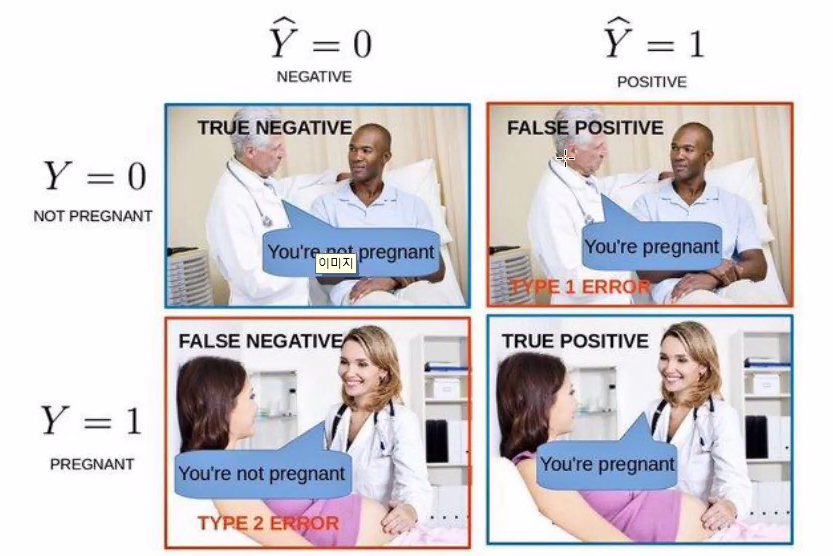

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred_rf) 
#TN, FP #N으로 예측했을 때 참인 것(실제도 N)
#FN, TP 

array([[103,   7],
       [ 25,  44]])

In [63]:
confusion_matrix(y_test,pred_my) 

array([[96, 14],
       [24, 45]])

In [64]:
from sklearn.metrics import precision_score, recall_score


In [66]:
# 정밀도(precision score TP / (FP+TP))
precision_score(y_test,pred_rf), precision_score(y_test,pred_my)

(0.8627450980392157, 0.7627118644067796)

In [67]:
# 재현율(Recall TP / (FN + TP))
recall_score(y_test, pred_rf), recall_score(y_test,pred_my)

(0.6376811594202898, 0.6521739130434783)

In [69]:
# F1 Score (정밀도와 재현율의 조화 평균)
from sklearn.metrics import f1_score
f1_score(y_test,pred_rf), f1_score(y_test,pred_my)

(0.7333333333333333, 0.703125)

In [70]:
# AUC Score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_rf), roc_auc_score(y_test,pred_my)

(0.787022397891963, 0.7624505928853755)